In [1]:
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy import misc
from scipy import stats
import pickle
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib.lines import Line2D
# from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

In [2]:
repo = os.path.join('/home/sditom/us_hindecast_project/public')
fig_repo = os.path.join(repo,'figs')

In [4]:
# cd us_hindecast_project/public/data
# gsutil cp -r gs://us_crop_type_hindcast/usCrop_tableExports_priorCorn . 

In [5]:
# This script is to compare NASS corn soy rotation with Rotation according to our maps


In [6]:
# Load NASS data
nass = pd.read_csv(os.path.join(repo,'data','nass','rotation','nass.priorCrop_clean.csv'))
print(nass.shape)
nass.head()

(39, 8)


,state,year,corn_estimate,corn_RSE,corn_stat_unrelaible,soy_estimate,soy_RSE,soy_stat_unrelaible
0,ND,2001,114.89,0.0,1.0,252.66,0.0,1.0
1,SD,2001,398.77,0.0,1.0,2796.68,0.0,0.0
2,NE,2001,3215.92,0.0,0.0,4186.42,0.0,0.0
3,KS,2001,922.64,0.0,0.0,1416.65,0.0,0.0
4,MO,2001,152.78,0.0,1.0,2409.23,0.0,0.0


In [7]:
nass = nass.rename({'corn_estimate':'nass_corn','soy_estimate':'nass_soy','state':'STATE_ABBR'},axis=1)
nass.head()

,STATE_ABBR,year,nass_corn,corn_RSE,corn_stat_unrelaible,nass_soy,soy_RSE,soy_stat_unrelaible
0,ND,2001,114.89,0.0,1.0,252.66,0.0,1.0
1,SD,2001,398.77,0.0,1.0,2796.68,0.0,0.0
2,NE,2001,3215.92,0.0,0.0,4186.42,0.0,0.0
3,KS,2001,922.64,0.0,0.0,1416.65,0.0,0.0
4,MO,2001,152.78,0.0,1.0,2409.23,0.0,0.0


In [8]:
# Load 2001,2005 and 2010 data for csdl
csdl_2001 = pd.read_csv(os.path.join(repo,'data','usCrop_tableExports_priorCorn',
                                '2001_Corn_cropsYearPrior_hidecast_map_v3masked_byState.csv'))
csdl_2005 = pd.read_csv(os.path.join(repo,'data','usCrop_tableExports_priorCorn',
                                '2005_Corn_cropsYearPrior_hidecast_map_v3masked_byState.csv'))
csdl_2010 = pd.read_csv(os.path.join(repo,'data','usCrop_tableExports_priorCorn',
                                '2010_Corn_cropsYearPrior_hidecast_map_v3masked_byState.csv'))
df_list = [csdl_2001,csdl_2005,csdl_2010]
csdl = pd.concat(df_list, axis=0)
csdl = csdl.drop(['system:index','DRAWSEQ','SUB_REGION','groups','.geo'],axis=1)
print(csdl.shape)#  13states*3years=39
csdl.head()

(39, 8)


,0,1,5,STATE_ABBR,STATE_FIPS,STATE_NAME,area,year
0,2.724488e+09,3.060078e+09,3.788646e+09,MI,26,Michigan,72555800.0,2001
1,3.030921e+09,8.088225e+09,3.417992e+09,WI,55,Wisconsin,70941500.0,2001
2,2.360951e+09,3.335028e+09,1.688456e+10,MN,27,Minnesota,113537000.0,2001
3,1.392439e+09,3.547259e+08,8.499574e+08,ND,38,North Dakota,99086800.0,2001
4,5.008796e+09,3.260199e+09,8.980815e+09,SD,46,South Dakota,96940000.0,2001


In [9]:
csdl = csdl.rename({'1':'csdl_corn','5':'csdl_soy'},axis=1)
csdl.head()

,0,csdl_corn,csdl_soy,STATE_ABBR,STATE_FIPS,STATE_NAME,area,year
0,2.724488e+09,3.060078e+09,3.788646e+09,MI,26,Michigan,72555800.0,2001
1,3.030921e+09,8.088225e+09,3.417992e+09,WI,55,Wisconsin,70941500.0,2001
2,2.360951e+09,3.335028e+09,1.688456e+10,MN,27,Minnesota,113537000.0,2001
3,1.392439e+09,3.547259e+08,8.499574e+08,ND,38,North Dakota,99086800.0,2001
4,5.008796e+09,3.260199e+09,8.980815e+09,SD,46,South Dakota,96940000.0,2001


In [10]:
## merge datasets

In [11]:
df = nass.merge(csdl, on=['STATE_ABBR','year'],how = 'left')
df.head()

,STATE_ABBR,year,nass_corn,corn_RSE,corn_stat_unrelaible,nass_soy,soy_RSE,soy_stat_unrelaible,0,csdl_corn,csdl_soy,STATE_FIPS,STATE_NAME,area
0,ND,2001,114.89,0.0,1.0,252.66,0.0,1.0,1.392439e+09,3.547259e+08,8.499574e+08,38,North Dakota,99086800.0
1,SD,2001,398.77,0.0,1.0,2796.68,0.0,0.0,5.008796e+09,3.260199e+09,8.980815e+09,46,South Dakota,96940000.0
2,NE,2001,3215.92,0.0,0.0,4186.42,0.0,0.0,4.502410e+09,2.299892e+10,1.136532e+10,31,Nebraska,88396600.0
3,KS,2001,922.64,0.0,0.0,1416.65,0.0,0.0,6.566657e+09,7.015541e+09,2.699424e+09,20,Kansas,86012200.0
4,MO,2001,152.78,0.0,1.0,2409.23,0.0,0.0,1.416826e+09,3.183899e+09,6.696263e+09,29,Missouri,72863800.0


In [12]:
df['nass_tot'] = df['nass_corn']+df['nass_soy']
df['nass_corn_corn'] = df['nass_corn']/df['nass_tot']
df['nass_soy_corn'] = df['nass_soy']/df['nass_tot']
df.head()

,STATE_ABBR,year,nass_corn,corn_RSE,corn_stat_unrelaible,nass_soy,soy_RSE,soy_stat_unrelaible,0,csdl_corn,csdl_soy,STATE_FIPS,STATE_NAME,area,nass_tot,nass_corn_corn,nass_soy_corn
0,ND,2001,114.89,0.0,1.0,252.66,0.0,1.0,1.392439e+09,3.547259e+08,8.499574e+08,38,North Dakota,99086800.0,367.55,0.312583,0.687417
1,SD,2001,398.77,0.0,1.0,2796.68,0.0,0.0,5.008796e+09,3.260199e+09,8.980815e+09,46,South Dakota,96940000.0,3195.45,0.124793,0.875207
2,NE,2001,3215.92,0.0,0.0,4186.42,0.0,0.0,4.502410e+09,2.299892e+10,1.136532e+10,31,Nebraska,88396600.0,7402.34,0.434446,0.565554
3,KS,2001,922.64,0.0,0.0,1416.65,0.0,0.0,6.566657e+09,7.015541e+09,2.699424e+09,20,Kansas,86012200.0,2339.29,0.394410,0.605590
4,MO,2001,152.78,0.0,1.0,2409.23,0.0,0.0,1.416826e+09,3.183899e+09,6.696263e+09,29,Missouri,72863800.0,2562.01,0.059633,0.940367


In [13]:
df['csdl_tot'] = df['csdl_corn']+df['csdl_soy']
df['csdl_corn_corn'] = df['csdl_corn']/df['csdl_tot']
df['csdl_soy_corn'] = df['csdl_soy']/df['csdl_tot']

In [14]:
df['csdl_ratio_soy_corn'] = df['csdl_soy']/df['csdl_corn']
df['nass_ratio_soy_corn'] = df['nass_soy']/df['nass_corn']

In [15]:
df.head()

,STATE_ABBR,year,nass_corn,corn_RSE,corn_stat_unrelaible,nass_soy,soy_RSE,soy_stat_unrelaible,0,csdl_corn,...,STATE_NAME,area,nass_tot,nass_corn_corn,nass_soy_corn,csdl_tot,csdl_corn_corn,csdl_soy_corn,csdl_ratio_soy_corn,nass_ratio_soy_corn
0,ND,2001,114.89,0.0,1.0,252.66,0.0,1.0,1.392439e+09,3.547259e+08,...,North Dakota,99086800.0,367.55,0.312583,0.687417,1.204683e+09,0.294456,0.705544,2.396096,2.199147
1,SD,2001,398.77,0.0,1.0,2796.68,0.0,0.0,5.008796e+09,3.260199e+09,...,South Dakota,96940000.0,3195.45,0.124793,0.875207,1.224101e+10,0.266334,0.733666,2.754683,7.013266
2,NE,2001,3215.92,0.0,0.0,4186.42,0.0,0.0,4.502410e+09,2.299892e+10,...,Nebraska,88396600.0,7402.34,0.434446,0.565554,3.436425e+10,0.669269,0.330731,0.494168,1.301780
3,KS,2001,922.64,0.0,0.0,1416.65,0.0,0.0,6.566657e+09,7.015541e+09,...,Kansas,86012200.0,2339.29,0.394410,0.605590,9.714966e+09,0.722138,0.277862,0.384778,1.535431
4,MO,2001,152.78,0.0,1.0,2409.23,0.0,0.0,1.416826e+09,3.183899e+09,...,Missouri,72863800.0,2562.01,0.059633,0.940367,9.880162e+09,0.322252,0.677748,2.103164,15.769276


/home/sditom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


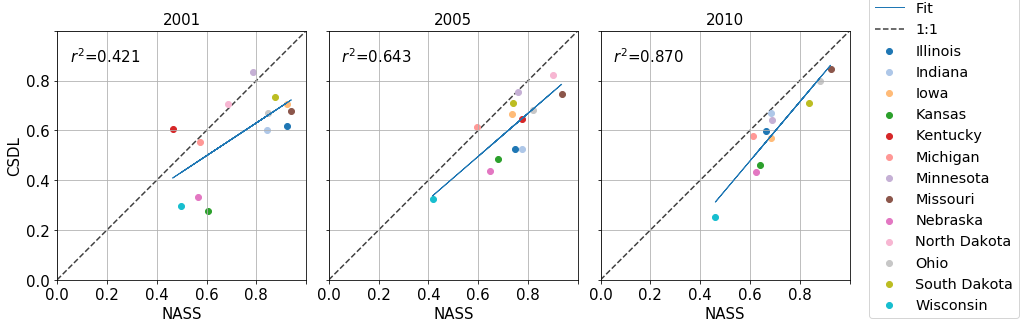

In [18]:
# Use this figure for Paper
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
fsize = 15
# fig.suptitle('Ratio of prior crop being soy for corn field in 2001, 2005 and 2010', y=0.99, fontsize=18)

NUM_COLORS = 13
cm = plt.get_cmap('tab20')
lm = linear_model.LinearRegression()
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.0)

for i,(id,group) in enumerate(df.groupby('year')):
    
    ax[i].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    ax[i].set_title(id,fontsize=fsize)
    ax[i].set_xlabel('NASS',fontsize=fsize)
    
#     group= group.dropna(subset=['nass_corn_corn','csdl_corn_corn'])
    for id2,group2 in group.groupby('STATE_NAME'):
        ax[i].scatter(group2['nass_soy_corn'],group2['csdl_soy_corn'],label=id2)
#         group2.plot('nass_corn_corn','csdl_corn_corn',ax=ax[i],label=id2)


    group= group.dropna(subset=['nass_soy_corn','csdl_soy_corn'])
    model = lm.fit(group[['nass_soy_corn']],group['csdl_soy_corn'])
    R2 = lm.score(group[['nass_soy_corn']],group['csdl_soy_corn'])
#     print(R2)

    predictions = lm.predict(group[['nass_soy_corn']])
    ax[i].plot(group[['nass_soy_corn']], predictions, linewidth=1)
    ax[i].text(0.05, 0.9, '$r^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i].transAxes)


    # plot 1:1 line
    ax[i].plot([0,1], [0,1], 'k--', alpha=0.75, zorder=0)
    ax[i].set_aspect('equal')
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([0,1])
    ax[i].grid(True)
    ax[i].legend().set_visible(False)
    
    ax[i].set_yticklabels('', rotation=0)

    
ax[0].set_ylabel('CSDL',fontsize=fsize)
ylabels = xlabels = np.arange(0,10, 2)/10
ax[0].set_yticklabels(ylabels,fontsize=fsize)
ax[0].set_xticklabels(xlabels,fontsize=fsize)
ax[1].set_xticklabels(xlabels,fontsize=fsize)
ax[2].set_xticklabels(xlabels,fontsize=fsize)


# Create the legend
colors=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
mylabels = ['Fit','1:1','Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Michigan', 'Minnesota',
 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']

fig.legend(lines,     # The line objects
           labels=mylabels,   # The labels for each line
           loc="lower right",   # Position of legend
           bbox_to_anchor=(0.95, 0.03),
           fontsize = 'x-large'
           )

fig.tight_layout(rect=[0,0,0.8,1])

fig.savefig(os.path.join(fig_repo,'Verification_Rotation_nassVsCSDL_SoyCorn_2001_2005_2010.png'.format(id)))

/home/sditom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


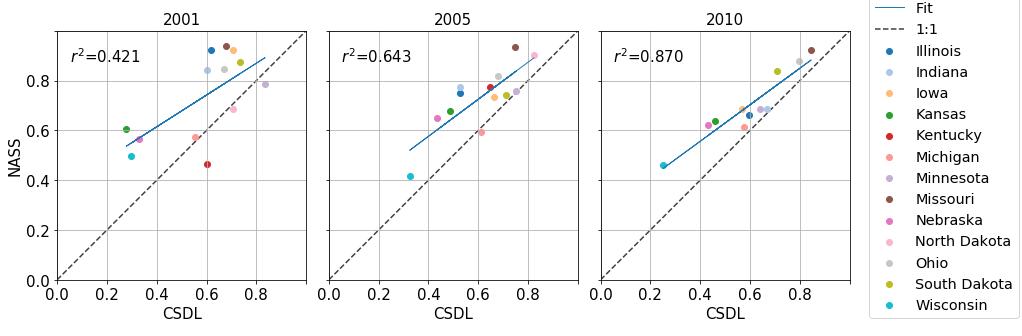

In [17]:
# ## invert x-y axis?

# fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
# fsize = 15

# NUM_COLORS = 13
# cm = plt.get_cmap('tab20')
# lm = linear_model.LinearRegression()
# bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.0)

# for i,(id,group) in enumerate(df.groupby('year')):
    
#     ax[i].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
#     ax[i].set_title(id,fontsize=fsize)
#     ax[i].set_xlabel('CSDL',fontsize=fsize)
    
# #     group= group.dropna(subset=['nass_corn_corn','csdl_corn_corn'])
#     for id2,group2 in group.groupby('STATE_NAME'):
#         ax[i].scatter(group2['csdl_soy_corn'],group2['nass_soy_corn'],label=id2)
# #         group2.plot('nass_corn_corn','csdl_corn_corn',ax=ax[i],label=id2)


#     group= group.dropna(subset=['csdl_soy_corn','nass_soy_corn'])
#     model = lm.fit(group[['csdl_soy_corn']],group['nass_soy_corn'])
#     R2 = lm.score(group[['csdl_soy_corn']],group['nass_soy_corn'])
# #     print(R2)

#     predictions = lm.predict(group[['csdl_soy_corn']])
#     ax[i].plot(group[['csdl_soy_corn']], predictions, linewidth=1)
#     ax[i].text(0.05, 0.9, '$r^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i].transAxes)


#     # plot 1:1 line
#     ax[i].plot([0,1], [0,1], 'k--', alpha=0.75, zorder=0)
#     ax[i].set_aspect('equal')
#     ax[i].set_xlim([0,1])
#     ax[i].set_ylim([0,1])
#     ax[i].grid(True)
#     ax[i].legend().set_visible(False)
    
#     ax[i].set_yticklabels('', rotation=0)

    
# ax[0].set_ylabel('NASS',fontsize=fsize)
# ylabels = xlabels = np.arange(0,10, 2)/10
# ax[0].set_yticklabels(ylabels,fontsize=fsize)
# ax[0].set_xticklabels(xlabels,fontsize=fsize)
# ax[1].set_xticklabels(xlabels,fontsize=fsize)
# ax[2].set_xticklabels(xlabels,fontsize=fsize)


# # Create the legend
# colors=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

# lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
# mylabels = ['Fit','1:1','Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Michigan', 'Minnesota',
#  'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']

# fig.legend(lines,     # The line objects
#            labels=mylabels,   # The labels for each line
#            loc="lower right",   # Position of legend
#            bbox_to_anchor=(0.95, 0.03),
#            fontsize = 'x-large'
#            )

# fig.tight_layout(rect=[0,0,0.8,1])

# # fig.savefig(os.path.join(fig_repo,'Verification_Rotation_nassVsCSDL_SoyCorn_2001_2005_2010.png'.format(id)))